Deep Learning
=============

Assignment 5
------------

The goal of this assignment is to train a Word2Vec skip-gram model over [Text8](http://mattmahoney.net/dc/textdata) data.

In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
%matplotlib inline
from __future__ import print_function
import collections
import math
import numpy as np
import os
import random
import tensorflow as tf
from tensorflow.contrib.tensorboard.plugins import projector
import zipfile
from matplotlib import pylab
from six.moves import range
from six.moves.urllib.request import urlretrieve
from sklearn.manifold import TSNE

Download the data from the source website if necessary.

In [2]:
url = 'http://mattmahoney.net/dc/'

def maybe_download(filename, expected_bytes):
  """Download a file if not present, and make sure it's the right size."""
  if not os.path.exists(filename):
    filename, _ = urlretrieve(url + filename, filename)
  statinfo = os.stat(filename)
  if statinfo.st_size == expected_bytes:
    print('Found and verified %s' % filename)
  else:
    print(statinfo.st_size)
    raise Exception(
      'Failed to verify ' + filename + '. Can you get to it with a browser?')
  return filename

filename = maybe_download('text8.zip', 31344016)

Found and verified text8.zip


Read the data into a string.

In [3]:
def read_data(filename):
  """Extract the first file enclosed in a zip file as a list of words"""
  with zipfile.ZipFile(filename) as f:
    data = tf.compat.as_str(f.read(f.namelist()[0])).split()
  return data
  
words = read_data(filename)
print('Data size %d' % len(words))

Data size 17005207


Build the dictionary and replace rare words with UNK token.

In [4]:
vocabulary_size = 50000

def build_dataset(words):
  count = [['UNK', -1]]
  count.extend(collections.Counter(words).most_common(vocabulary_size - 1))
  dictionary = dict()
  for word, _ in count:
    dictionary[word] = len(dictionary)
  data = list()
  unk_count = 0
  for word in words:
    if word in dictionary:
      index = dictionary[word]
    else:
      index = 0  # dictionary['UNK']
      unk_count = unk_count + 1
    data.append(index)
  count[0][1] = unk_count
  reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys())) 
  return data, count, dictionary, reverse_dictionary

data, count, dictionary, reverse_dictionary = build_dataset(words)
print('Most common words (+UNK)', count[:5])
print('Sample data', data[:10])
del words  # Hint to reduce memory.

Most common words (+UNK) [['UNK', 418391], ('the', 1061396), ('of', 593677), ('and', 416629), ('one', 411764)]
Sample data [5238, 3082, 12, 6, 195, 2, 3135, 46, 59, 156]


Function to generate a training batch for the skip-gram model.

In [5]:
data_index = 0

def generate_batch(batch_size, num_skips, skip_window):
  global data_index
  assert batch_size % num_skips == 0
  assert num_skips <= 2 * skip_window
  batch = np.ndarray(shape=(batch_size), dtype=np.int32)
  labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
  span = 2 * skip_window + 1 # [ skip_window target skip_window ]
  buffer = collections.deque(maxlen=span)
  for _ in range(span):
    buffer.append(data[data_index])
    data_index = (data_index + 1) % len(data)
  for i in range(batch_size // num_skips):
    target = skip_window  # target label at the center of the buffer
    targets_to_avoid = [ skip_window ]
    for j in range(num_skips):
      while target in targets_to_avoid:
        target = random.randint(0, span - 1)
      targets_to_avoid.append(target)
      batch[i * num_skips + j] = buffer[skip_window]
      labels[i * num_skips + j, 0] = buffer[target]
    buffer.append(data[data_index])
    data_index = (data_index + 1) % len(data)
  return batch, labels

print('data:', [reverse_dictionary[di] for di in data[:8]])

for num_skips, skip_window in [(2, 1), (4, 2)]:
    data_index = 0
    batch, labels = generate_batch(batch_size=8, num_skips=num_skips, skip_window=skip_window)
    print('\nwith num_skips = %d and skip_window = %d:' % (num_skips, skip_window))
    print('    batch:', [reverse_dictionary[bi] for bi in batch])
    print('    labels:', [reverse_dictionary[li] for li in labels.reshape(8)])

data: ['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first']

with num_skips = 2 and skip_window = 1:
    batch: ['originated', 'originated', 'as', 'as', 'a', 'a', 'term', 'term']
    labels: ['as', 'anarchism', 'a', 'originated', 'as', 'term', 'of', 'a']

with num_skips = 4 and skip_window = 2:
    batch: ['as', 'as', 'as', 'as', 'a', 'a', 'a', 'a']
    labels: ['term', 'originated', 'anarchism', 'a', 'of', 'as', 'originated', 'term']


Train a skip-gram model.

In [6]:
batch_size = 128
embedding_size = 128 # Dimension of the embedding vector.
skip_window = 1 # How many words to consider left and right.
num_skips = 2 # How many times to reuse an input to generate a label.
# We pick a random validation set to sample nearest neighbors. here we limit the
# validation samples to the words that have a low numeric ID, which by
# construction are also the most frequent. 
valid_size = 16 # Random set of words to evaluate similarity on.
valid_window = 100 # Only pick dev samples in the head of the distribution.
valid_examples = np.array(random.sample(range(valid_window), valid_size))
num_sampled = 64 # Number of negative examples to sample.

graph = tf.Graph()

with graph.as_default(), tf.device('/cpu:0'):

  # Input data.
  train_dataset = tf.placeholder(tf.int32, shape=[batch_size])
  train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
  valid_dataset = tf.constant(valid_examples, dtype=tf.int32)
  
  # Variables.
  embeddings = tf.Variable(
    tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
  softmax_weights = tf.Variable(
    tf.truncated_normal([vocabulary_size, embedding_size],
                         stddev=1.0 / math.sqrt(embedding_size)))
  softmax_biases = tf.Variable(tf.zeros([vocabulary_size]))
  
  # Model.
  # Look up embeddings for inputs.
  embed = tf.nn.embedding_lookup(embeddings, train_dataset)
  # Compute the softmax loss, using a sample of the negative labels each time.
  loss = tf.reduce_mean(
    tf.nn.sampled_softmax_loss(weights=softmax_weights, biases=softmax_biases, inputs=embed,
                               labels=train_labels, num_sampled=num_sampled, num_classes=vocabulary_size))

  # Optimizer.
  # Note: The optimizer will optimize the softmax_weights AND the embeddings.
  # This is because the embeddings are defined as a variable quantity and the
  # optimizer's `minimize` method will by default modify all variable quantities 
  # that contribute to the tensor it is passed.
  # See docs on `tf.train.Optimizer.minimize()` for more details.
  optimizer = tf.train.AdagradOptimizer(1.0).minimize(loss)
  
  # Compute the similarity between minibatch examples and all embeddings.
  # We use the cosine distance:
  norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
  normalized_embeddings = embeddings / norm
  valid_embeddings = tf.nn.embedding_lookup(
    normalized_embeddings, valid_dataset)
  similarity = tf.matmul(valid_embeddings, tf.transpose(normalized_embeddings))

In [7]:
num_steps = 100001

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print('Initialized')
  average_loss = 0
  for step in range(num_steps):
    batch_data, batch_labels = generate_batch(
      batch_size, num_skips, skip_window)
    feed_dict = {train_dataset : batch_data, train_labels : batch_labels}
    _, l = session.run([optimizer, loss], feed_dict=feed_dict)
    average_loss += l
    if step % 2000 == 0:
      if step > 0:
        average_loss = average_loss / 2000
      # The average loss is an estimate of the loss over the last 2000 batches.
      print('Average loss at step %d: %f' % (step, average_loss))
      average_loss = 0
    # note that this is expensive (~20% slowdown if computed every 500 steps)
    if step % 10000 == 0:
      sim = similarity.eval()
      for i in range(valid_size):
        valid_word = reverse_dictionary[valid_examples[i]]
        top_k = 8 # number of nearest neighbors
        nearest = (-sim[i, :]).argsort()[1:top_k+1]
        log = 'Nearest to %s:' % valid_word
        for k in range(top_k):
          close_word = reverse_dictionary[nearest[k]]
          log = '%s %s,' % (log, close_word)
        print(log)
  final_embeddings = normalized_embeddings.eval()

Initialized
Average loss at step 0: 7.659822
Nearest to over: committed, bolo, psychotherapist, snippets, confidant, curule, asphalt, protectorates,
Nearest to no: zork, leszek, dolmens, glasnevin, acknowledgement, ost, magadha, postures,
Nearest to be: pergamon, multinational, fermi, decca, grim, benno, rosicrucians, insulation,
Nearest to this: rature, career, tripartite, bordered, mycoplasma, copula, brisk, witty,
Nearest to were: nora, angilbert, differentiability, oblique, nachrichten, arnaz, waff, fragmentary,
Nearest to UNK: walkways, landmass, goodness, perpetrator, tumble, alkynes, gkos, bodybuilding,
Nearest to was: reorganised, meanings, anxieties, rationals, photius, decreed, drury, justification,
Nearest to nine: bastille, aulus, anecdotal, east, consultancy, muskegon, bitola, realising,
Nearest to there: biot, westminster, arbitrary, miscarriage, saeed, archeologists, sniper, list,
Nearest to which: bender, inducted, constantly, trypanosomiasis, reorganised, pronunciation

In [8]:
num_points = 400

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
two_d_embeddings = tsne.fit_transform(final_embeddings[1:num_points+1, :])

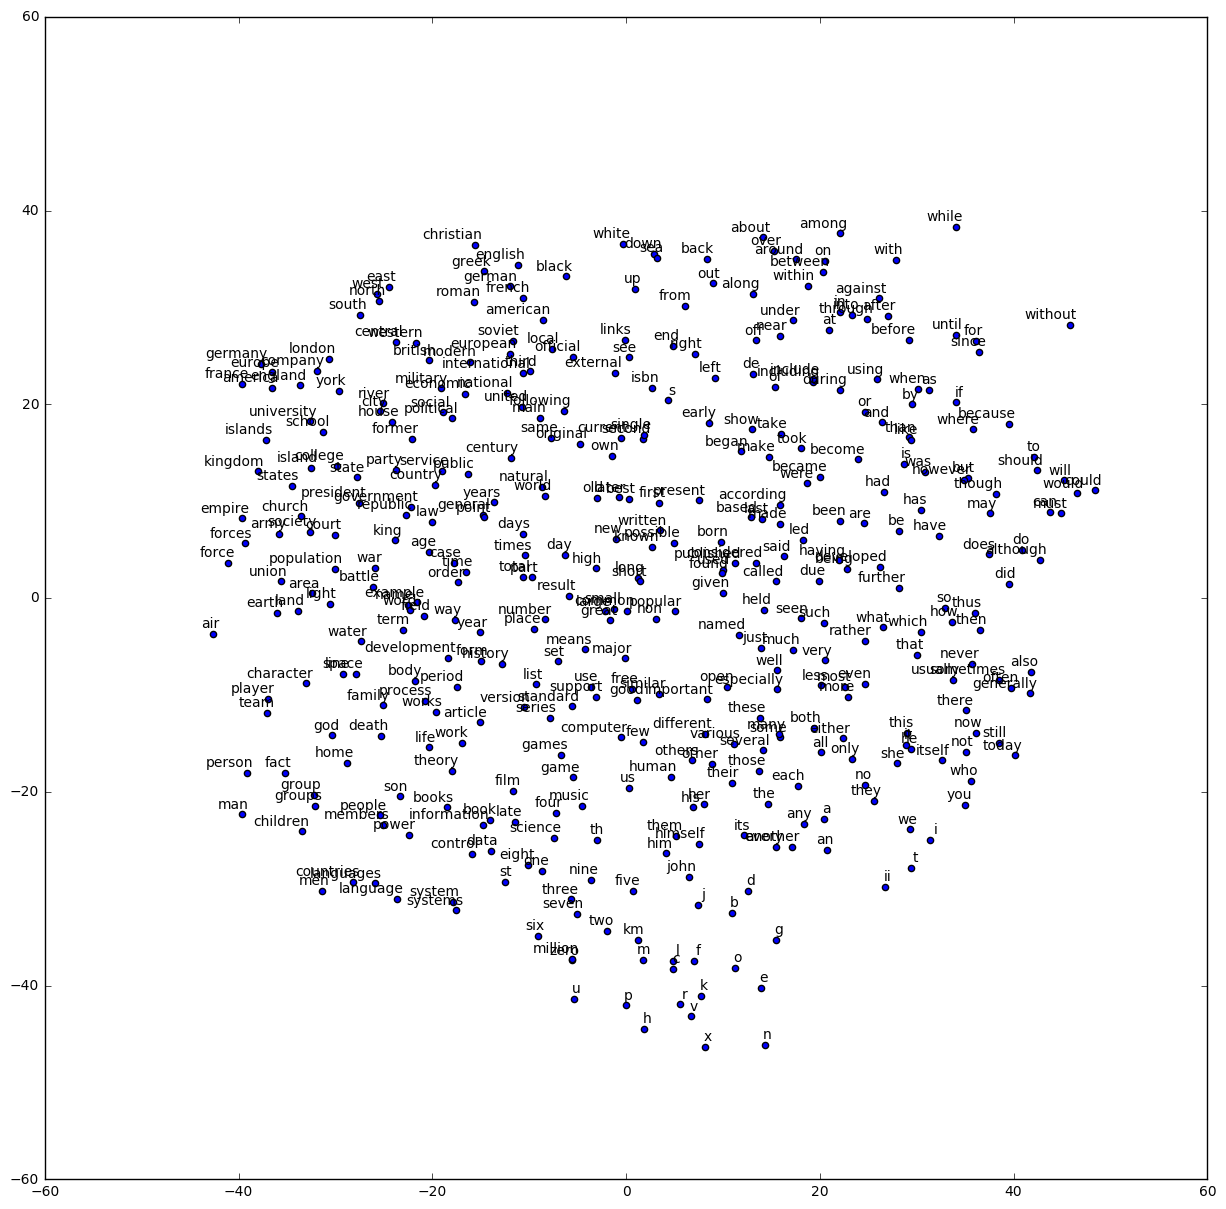

In [9]:
def plot(embeddings, labels):
  assert embeddings.shape[0] >= len(labels), 'More labels than embeddings'
  pylab.figure(figsize=(15,15))  # in inches
  for i, label in enumerate(labels):
    x, y = embeddings[i,:]
    pylab.scatter(x, y)
    pylab.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
                   ha='right', va='bottom')
  pylab.show()

words = [reverse_dictionary[i] for i in range(1, num_points+1)]
plot(two_d_embeddings, words)

---

Problem
-------

An alternative to skip-gram is another Word2Vec model called [CBOW](http://arxiv.org/abs/1301.3781) (Continuous Bag of Words). In the CBOW model, instead of predicting a context word from a word vector, you predict a word from the sum of all the word vectors in its context. Implement and evaluate a CBOW model trained on the text8 dataset.

---

## Continuous bag of words
Similar to the Skip gram, but instead of the adjacent words being targets given a single word, the single word is the target given the sum of adjacent words.

In [6]:
data_index = 0

def generate_batch(batch_size, bag_window):
  global data_index
  span = 2 * bag_window + 1 # [ bag_window target bag_window ]
  batch = np.ndarray(shape=(batch_size, span - 1), dtype=np.int32)
  labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
  buffer = collections.deque(maxlen=span)
  for _ in range(span):
    buffer.append(data[data_index])
    data_index = (data_index + 1) % len(data)
  for i in range(batch_size):
    buffer_list = list(buffer)
    labels[i, 0] = buffer_list.pop(bag_window)
    batch[i] = buffer_list
    buffer.append(data[data_index])
    data_index = (data_index + 1) % len(data)
  return batch, labels

print('data:', [reverse_dictionary[di] for di in data[:8]])

for bag_window in (2, 1):
    data_index = 0
    batch, labels = generate_batch(batch_size=8, bag_window=bag_window)
    print('\nwith bag_window = %d:' % (bag_window))
    print('    batch:', [[reverse_dictionary[w] for w in bi] for bi in batch])
    print('    labels:', [reverse_dictionary[li] for li in labels.reshape(8)])

data: ['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first']

with bag_window = 2:
    batch: [['anarchism', 'originated', 'a', 'term'], ['originated', 'as', 'term', 'of'], ['as', 'a', 'of', 'abuse'], ['a', 'term', 'abuse', 'first'], ['term', 'of', 'first', 'used'], ['of', 'abuse', 'used', 'against'], ['abuse', 'first', 'against', 'early'], ['first', 'used', 'early', 'working']]
    labels: ['as', 'a', 'term', 'of', 'abuse', 'first', 'used', 'against']

with bag_window = 1:
    batch: [['anarchism', 'as'], ['originated', 'a'], ['as', 'term'], ['a', 'of'], ['term', 'abuse'], ['of', 'first'], ['abuse', 'used'], ['first', 'against']]
    labels: ['originated', 'as', 'a', 'term', 'of', 'abuse', 'first', 'used']


In [29]:
batch_size = 128
embedding_size = 128 # Dimension of the embedding vector.
bag_window = 2 # How many words to consider left and right.
# We pick a random validation set to sample nearest neighbors. here we limit the
# validation samples to the words that have a low numeric ID, which by
# construction are also the most frequent. 
valid_size = 16 # Random set of words to evaluate similarity on.
valid_window = 100 # Only pick dev samples in the head of the distribution.
valid_examples = np.array(random.sample(range(valid_window), valid_size))
num_sampled = 64 # Number of negative examples to sample.

graph = tf.Graph()

with graph.as_default(), tf.device('/cpu:0'):

  # Input data.
  train_dataset = tf.placeholder(tf.int32, shape=[batch_size, bag_window * 2])
  train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
  valid_dataset = tf.constant(valid_examples, dtype=tf.int32)
  
  # Variables.
  embeddings = tf.Variable(
    tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
  softmax_weights = tf.Variable(
    tf.truncated_normal([vocabulary_size, embedding_size],
                         stddev=1.0 / math.sqrt(embedding_size)))
  softmax_biases = tf.Variable(tf.zeros([vocabulary_size]))
  
  # Model.
  # Look up embeddings for inputs.
  embeds = tf.nn.embedding_lookup(embeddings, train_dataset)
  #Note embed is the embedding for all he train dataset words, not just one word like in skip gram
  # Compute the softmax loss, using a sample of the negative labels each time.
  #Note, the input is the sum of all the embeddings
  loss = tf.reduce_mean(
    tf.nn.sampled_softmax_loss(weights=softmax_weights, biases=softmax_biases, inputs=tf.reduce_sum(embeds, 1),
                               labels=train_labels, num_sampled=num_sampled, num_classes=vocabulary_size))

  # Optimizer.
  # Note: The optimizer will optimize the softmax_weights AND the embeddings.
  # This is because the embeddings are defined as a variable quantity and the
  # optimizer's `minimize` method will by default modify all variable quantities 
  # that contribute to the tensor it is passed.
  # See docs on `tf.train.Optimizer.minimize()` for more details.
  optimizer = tf.train.AdagradOptimizer(1.0).minimize(loss)
  
  # Compute the similarity between minibatch examples and all embeddings.
  # We use the cosine distance:
  norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
  normalized_embeddings = embeddings / norm
  valid_embeddings = tf.nn.embedding_lookup(
    normalized_embeddings, valid_dataset)
  similarity = tf.matmul(valid_embeddings, tf.transpose(normalized_embeddings))

In [30]:
num_steps = 100001

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print('Initialized')
  average_loss = 0
  for step in range(num_steps):
    batch_data, batch_labels = generate_batch(
      batch_size, bag_window)
    feed_dict = {train_dataset : batch_data, train_labels : batch_labels}
    _, l = session.run([optimizer, loss], feed_dict=feed_dict)
    average_loss += l
    if step % 2000 == 0:
      if step > 0:
        average_loss = average_loss / 2000
      # The average loss is an estimate of the loss over the last 2000 batches.
      print('Average loss at step %d: %f' % (step, average_loss))
      average_loss = 0
    # note that this is expensive (~20% slowdown if computed every 500 steps)
    if step % 10000 == 0:
      sim = similarity.eval()
      for i in range(valid_size):
        valid_word = reverse_dictionary[valid_examples[i]]
        top_k = 8 # number of nearest neighbors
        nearest = (-sim[i, :]).argsort()[1:top_k+1]
        log = 'Nearest to %s:' % valid_word
        for k in range(top_k):
          close_word = reverse_dictionary[nearest[k]]
          log = '%s %s,' % (log, close_word)
        print(log)
  final_embeddings = normalized_embeddings.eval()

Initialized
Average loss at step 0: 8.135355
Nearest to up: tomorrowland, heresy, promo, eligibility, biotic, cantata, blockage, deformity,
Nearest to between: norwegians, civic, translating, suffragan, sticker, glacial, iranians, soto,
Nearest to UNK: minorca, anxiolytic, naturalist, manga, adriaan, storytelling, phonation, mishandling,
Nearest to of: bithynia, kasner, nicolay, lots, bantu, clyde, mister, kinks,
Nearest to it: hermeneutics, capillary, duets, coo, liga, sumerian, swordsmen, elway,
Nearest to into: tumbling, corsairs, touring, polydor, mir, neptunian, bleed, router,
Nearest to over: seraphim, ecclesiastical, substantially, fief, ives, gadolinium, zaire, synergies,
Nearest to about: alle, botanicals, hilton, stabilization, polishing, linton, misnomer, stabilizer,
Nearest to for: sweetened, jungian, crafted, tours, uprooted, complex, fiat, designs,
Nearest to american: robert, grooming, shown, rest, scriptorium, donn, spaces, anesthesia,
Nearest to some: quito, cancelled,

In [31]:
num_points = 400

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
two_d_embeddings = tsne.fit_transform(final_embeddings[1:num_points+1, :])

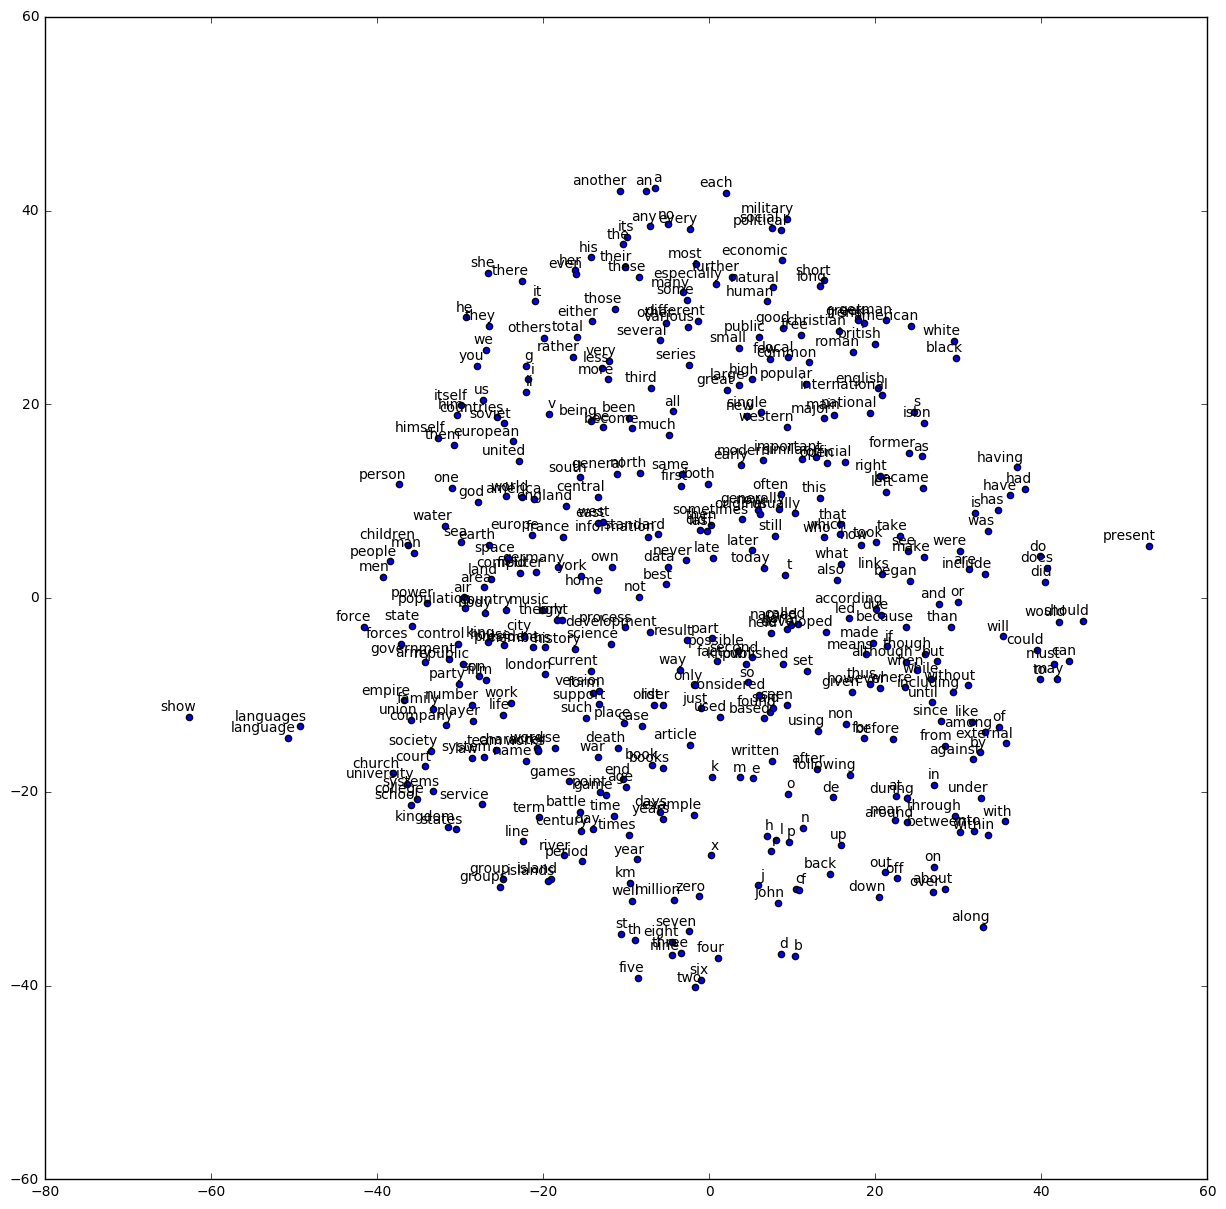

In [32]:
def plot(embeddings, labels):
  assert embeddings.shape[0] >= len(labels), 'More labels than embeddings'
  pylab.figure(figsize=(15,15))  # in inches
  for i, label in enumerate(labels):
    x, y = embeddings[i,:]
    pylab.scatter(x, y)
    pylab.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
                   ha='right', va='bottom')
  pylab.show()

words = [reverse_dictionary[i] for i in range(1, num_points+1)]
plot(two_d_embeddings, words)

# Try creating the model in a class

In [23]:
#All changeable parameters for the model

batch_size = 128
embedding_size = 128 # Dimension of the embedding vector.
bag_window = 2 # How many words to consider left and right.
valid_size = 16 # Random set of words to evaluate similarity on.
valid_window = 100 # Only pick dev samples in the head of the distribution.
valid_examples = np.array(random.sample(range(valid_window), valid_size))
num_sampled = 64 # Number of negative examples to sample.
learning_rate = 1.0


In [24]:
# Create the class for bag of words model

class BagOfWords:
    """ Build the graph for word2vec model """
    global train_dataset
    def __init__(self, valid_size, valid_window, vocabulary_size, valid_examples, embedding_size, batch_size, bag_window, num_sampled):
        self.valid_size = valid_size
        self.valid_window = valid_window
        self.valid_examples = valid_examples
        self.vocabulary_size = vocabulary_size
        self.embedding_size = embedding_size
        self.batch_size = batch_size
        self.bag_window = bag_window
        self.num_sampled = num_sampled
        self.learning_rate = learning_rate
        self.global_step = tf.Variable(0, dtype=tf.int32, trainable=False, name='global_step')
        
##    def _create_placeholders(self):
##       """ Step 1: define the placeholders for input and output """
##      with tf.name_scope("data"):
##         self.train_dataset = tf.placeholder(tf.int32, shape=[self.batch_size, self.bag_window * 2], name='train_dataset')
##        self.train_labels = tf.placeholder(tf.int32, shape=[self.batch_size, 1], name='train_labels')
##       self.valid_dataset = tf.constant(self.valid_examples, dtype=tf.int32, name='valid_dataset')

    def _create_embedding(self):
        """ Step 2: define weights. In word2vec, it's actually the weights that we care about """
        
        with tf.name_scope("embed"):
            self.embeddings = tf.Variable(
                            tf.random_uniform([self.vocabulary_size, self.embedding_size], -1.0, 1.0), name='embeddings')

    def _create_loss(self):
        """ Step 3 + 4: define the model + the loss function """
        with tf.name_scope("loss"):
            softmax_weights = tf.Variable(tf.truncated_normal([self.vocabulary_size, self.embedding_size],
                             stddev=1.0 / math.sqrt(self.embedding_size)), name='softmax_weights')
            
            softmax_biases = tf.Variable(tf.zeros([self.vocabulary_size]), name='softmax_biases')
            
            # Model.
            # Look up embeddings for inputs.
            embeds = tf.nn.embedding_lookup(self.embeddings, self.train_dataset, name='embeds')
            #Note embed is the embedding for all he train dataset words, not just one word like in skip gram
            # Compute the softmax loss, using a sample of the negative labels each time.
            #Note, the input is the sum of all the embeddings
            self.loss = tf.reduce_mean(
                tf.nn.sampled_softmax_loss(weights=softmax_weights, biases=softmax_biases, inputs=tf.reduce_sum(embeds, 1),
                               labels=self.train_labels, num_sampled=self.num_sampled, num_classes=self.vocabulary_size), name='loss')
            
    def _create_optimizer(self):
        """ Step 5: define optimizer """
        self.optimizer = tf.train.AdagradOptimizer(self.learning_rate).minimize(self.loss, global_step=self.global_step)
        # Compute the similarity between minibatch examples and all embeddings.
        # We use the cosine distance:
        norm = tf.sqrt(tf.reduce_sum(tf.square(self.embeddings), 1, keep_dims=True))
        self.normalized_embeddings = self.embeddings / norm
        self.valid_embeddings = tf.nn.embedding_lookup(
            self.normalized_embeddings, self.valid_dataset)
        self.similarity = tf.matmul(self.valid_embeddings, tf.transpose(self.normalized_embeddings))
    
    def _create_summaries(self):
        with tf.name_scope("summaries"):
            tf.summary.scalar("loss", self.loss)
            tf.summary.histogram("histogram_loss", self.loss)
            # because you have several summaries, we should merge them all
            # into one op to make it easier to manage
            self.summary_op = tf.summary.merge_all()
            
    def build_graph(self):
        """ Build the graph for our model """
        self._create_embedding()
        self._create_loss()
        self._create_optimizer()
        self._create_summaries()
        

In [25]:
def make_dir(path):
    """ Create a directory if there isn't one already. """
    try:
        os.mkdir(path)
    except OSError:
        pass

In [26]:
data_index = 0

def generate_batch(batch_size, bag_window):
  global data_index
  span = 2 * bag_window + 1 # [ bag_window target bag_window ]
  batch = np.ndarray(shape=(batch_size, span - 1), dtype=np.int32)
  labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
  buffer = collections.deque(maxlen=span)
  for _ in range(span):
    buffer.append(data[data_index])
    data_index = (data_index + 1) % len(data)
  for i in range(batch_size):
    buffer_list = list(buffer)
    labels[i, 0] = buffer_list.pop(bag_window)
    batch[i] = buffer_list
    buffer.append(data[data_index])
    data_index = (data_index + 1) % len(data)
  return batch, labels


In [27]:
""" Step 1: define the placeholders for input and output """
with tf.name_scope("data"):
    train_dataset = tf.placeholder(tf.int32, shape=[batch_size, bag_window * 2], name='train_dataset')
    train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1], name='train_labels')
    valid_dataset = tf.constant(valid_examples, dtype=tf.int32, name='valid_dataset')


num_steps = 100001

def train_model(model, num_steps, batch_size, bag_window):
    saver = tf.train.Saver() # defaults to saving all variables
    
    initial_step = 0
    
    make_dir('checkpoints')
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        ckpt = tf.train.get_checkpoint_state(os.path.dirname('checkpoints/checkpoint'))
        # if that checkpoint exists, restore from checkpoint
        if ckpt and ckpt.model_checkpoint_path:
            saver.restore(sess, ckpt.model_checkpoint_path)
        
        average_loss = 0
        
        writer = tf.summary.FileWriter('improved_graph/lr' + str(learning_rate), sess.graph)
        initial_step = model.global_step.eval()
        
        for step in range(initial_step, initial_step + num_steps):
            batch_data, batch_labels = generate_batch(batch_size, bag_window)
            tf.summary.scalar("loss", model.loss)
            tf.summary.histogram("histogram_loss", model.loss)
            # because you have several summaries, we should merge them all
            # into one op to make it easier to manage
            summary_op = tf.summary.merge_all()        
            feed_dict = {train_dataset : batch_data, train_labels : batch_labels}
            l, _, summary = sess.run([model.loss, model.optimizer, summary_op], feed_dict=feed_dict)
            average_loss += l

            
            writer.add_summary(summary, global_step=step)
            if step % 2000 == 0:
                if step > 0:
                    average_loss = average_loss / 2000
                    # The average loss is an estimate of the loss over the last 2000 batches.
                    print('Average loss at step %d: %f' % (step, average_loss))
                    average_loss = 0
            # note that this is expensive (~20% slowdown if computed every 500 steps)
            if step % 10000 == 0:
                sim = model.similarity.eval()
                for i in range(valid_size):
                    valid_word = reverse_dictionary[valid_examples[i]]
                    top_k = 8 # number of nearest neighbors
                    nearest = (-sim[i, :]).argsort()[1:top_k+1]
                    log = 'Nearest to %s:' % valid_word
                    for k in range(top_k):
                        close_word = reverse_dictionary[nearest[k]]
                        log = '%s %s,' % (log, close_word)
                print(log)
                saver.save(sess, 'checkpoints/skip-gram', index)

In [28]:
model = BagOfWords(valid_size=valid_size, valid_window=valid_window,
                   vocabulary_size=vocabulary_size, valid_examples=valid_examples,
                   embedding_size=embedding_size, batch_size=batch_size, bag_window=bag_window,
                   num_sampled=num_sampled)
model.build_graph()
train_model(model=model, num_steps=num_steps, batch_size=batch_size, bag_window=bag_window)

AttributeError: 'BagOfWords' object has no attribute 'train_dataset'